In [2]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import seaborn as sns
import EmotionEvaluationCorrelationHelper as helper
import matplotlib.pyplot as plt
import matplotlib
from IPython.core.pylabtools import figsize
from matplotlib.colors import ListedColormap
import scipy.stats as stats
import matplotlib.patches as mpatches
from labellines import labelLine, labelLines

In [3]:
df_study_1 = pd.read_csv('../data/study1_olr.csv', delimiter='\t')
df_study_2 = pd.read_csv('../data/study2_olr.csv', delimiter='\t')
df_study_3 = pd.read_csv('../data/study3_olr.csv', delimiter='\t')
df_study_4 = pd.read_csv('../data/study4_olr_formatted.csv', delimiter=',')

In [4]:
#enforcing consistent naming conventions for emotion concepts
df_study_1 = df_study_1.rename(str,columns={"ExcitedPleasant":"ExcitementPleasant",
                                            "ExcitedGood":"ExcitementGood",
                                           "SurprisedGood":"SurpriseGood",
                                           "SurprisedPleasant":"SurprisePleasant"})
df_study_2 = df_study_2.rename(str,columns={"SadnessPleasant":"SadPleasant",
                                            "SadnessGood":"SadGood"})
df_study_4 = df_study_4.rename(str,columns={"HappyPleasant":"HappinessPleasant",
                                            "HappyGood":"HappinessGood",
                                            "SadnessPleasant":"SadPleasant",
                                            "SadnessGood":"SadGood"})

#concat all data
all_data = pd.concat([df_study_1,df_study_2,df_study_4])

/Users/phoenix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


## Calc Significance

In [5]:
def GetDfWithTsRs(df,value_dimension_1, value_dimension_2):
    
    columns = df.columns
    emotion_concepts = [i.split(value_dimension_1)[0] for i in columns if len(i.split(value_dimension_1))>1]
    
    r_p_vals = []
    pairwise_corr = []
    dissimilarity_score = []
    
    mean_diff_vals = []
    t_vals = []
    t_p_vals = []
    
    for emotion in emotion_concepts:
        
        good_column = emotion + str(value_dimension_1)
        pleasant_column = emotion + str(value_dimension_2)
        clean_df = df[[good_column,pleasant_column]].dropna()
        
        good_column_vals = clean_df[good_column]
        pleasant_column_vals = clean_df[pleasant_column]
        
        t, p_t = stats.ttest_ind(good_column_vals,pleasant_column_vals)
        mean_difference = abs(good_column_vals.mean() - pleasant_column_vals.mean())
        mean_diff_vals.append(mean_difference)
        t_vals.append(t)
        t_p_vals.append(p_t)
        
        r, p_r = stats.stats.pearsonr(good_column_vals, pleasant_column_vals)
        pairwise_corr.append(r)
        r_p_vals.append(p_r)
        dissimilarity_score.append((1 - r)/2)
    return pd.DataFrame(
              data={'emotions' : emotion_concepts,
                    'r_vals':pairwise_corr,
                    'r_p_vals':r_p_vals,
                    'dissimilarity_score':dissimilarity_score,
                   't_vals':t_vals,
                   't_p_vals':t_p_vals,
                   'mean_difference':mean_diff_vals})

In [6]:
def label_point_matplotlib(x,
                           y,
                           culture_effect_size,
                           val,
                           size,
                           min_size,
                           ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        np = culture_effect_size[i]
        current_size = size[i]
        emo_str = str(point['val'])
        x_default_offset = .0013 * len(emo_str)
        x_cordinate=point['x']
        x_cord = x_cordinate - x_default_offset
        y_cord = CalcYCoordinate(x, y, x_cord, point['y'], current_size)
        ax.text(x_cord, y_cord,str(point['val']))
                
            
def CalcYCoordinate(x_coords, y_coords, current_x, current_y, size):
    # if there is an X coordinate with a difference less then X from this and a y that is less then
    #x amount different make the y change sign negative
        diff_x_cords = x_coords - current_x
        diff_y_cords = y_coords - current_y
        close_other_x_cords = all(abs(x) > .007 or abs(x)==0 for x in diff_x_cords)
        no_close_greater_y_cords = all(y <= 0 or y > .24 for y in diff_y_cords)
        
        y_offset_sign = -1.3 if not no_close_greater_y_cords and not close_other_x_cords else 1.2
        
        return current_y +  y_offset_sign * (.5 * size**.5/500**.5)
    

def AssignSizeFromCount(num_vals_for_col):
    size = []
    for val in num_vals_for_col:
        if(val <=42):
            size.append(500)
        elif (val <= 214):
            size.append(750)
        elif (val <= 320):
            size.append(1000)
        else:
            size.append(1250)
    return size


def AssignColorGradient (t_p_val, palette):
    colors = []
    p_bins = np.linspace(.05,0,num_bins)
    for i in range(len(t_p_val)):
        p = t_p_val[i]
        if(p > .05):
            colors.append((.90,.90,.90))
        elif p>.01:
            colors.append(palette[0])
        elif p>.001:
            colors.append(palette[1])
        else:
            colors.append(palette[2])
            #color_idx = min(range(len(p_bins)), key=lambda i: abs(p_bins[i]-p))
            #colors.append(palette[color_idx])#red
        
    return colors

def AssignHatch(culture_np):
    hatches = []
    for i in range(len(culture_np)):
        np = culture_np[i]
        if(np>=.05):
            hatches.append('||')
        elif(np>0):
            hatches.append('..')
        else:
            hatches.append("")
    return hatches

In [7]:
df_with_stats = GetDfWithTsRs(all_data, 'Pleasant','Good')
df_with_stats = df_with_stats.sort_values('r_vals',ascending=True).reset_index()

one_emotion_valuation_col_name = [emotion + 'Pleasant' for emotion in df_with_stats['emotions']]
data_counts = all_data[one_emotion_valuation_col_name].count()
df_with_stats['size'] = AssignSizeFromCount(data_counts)
effect_size_culture_interaction = [ 
    0.05,#guilt
    0.00,#tense
    0.00,#Frustrated
    0.00,#Depressed
    0.06,#Shame
    0.1,#Anger
    0.01,#lust
    0.01,#Fear,
    0.0,#Bored,
    0.02,#Disgust
    0.0,#Love
    0.06,#SAd
    0.02,#Calm
    0.0,#Distressed,
    0.04,#excitement
    0.02,#Happiness
    0.03,#pride
    0.05,#surprise
    0.00,#awe
    0.00,#jealousy
    0.,#joy
    0.,#miserabel
]

df_with_stats['culture_np'] = effect_size_culture_interaction 
df_with_stats['culture_study']=[1,0,0,0,1,1,1,1,0,1,0,1,1,0,1,1,1,1,0,0,0,0]#if in culture == 1


## Base Figure

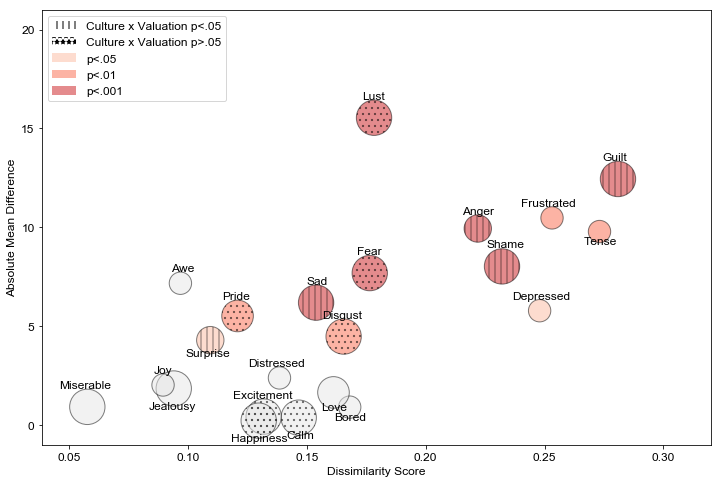

In [8]:
plt.rcParams.update({'font.size': 12,
                    'font.family':'Arial'})

num_bins = 3
palette = sns.color_palette("Reds",num_bins)
colors = np.array(AssignColorGradient(df_with_stats['t_p_vals'], palette))
hatches = AssignHatch(df_with_stats.culture_np)

fig, ax = plt.subplots()

fig.set_size_inches(12,8)
ax.set_ylim(-1,21)
ax.set_yticks(np.linspace(0,20,5))
ax.set_ylabel('Absolute Mean Difference')
ax.set_xlabel('Dissimilarity Score')

circ1 = mpatches.Patch(alpha=0,hatch='||',label='Culture x Valuation p<.05')
circ2= mpatches.Patch(alpha=0,hatch='**',label='Culture x Valuation p>.05')
circ3= mpatches.Patch(alpha=.5,facecolor=palette[0],label='p<.05')
circ4= mpatches.Patch(alpha=.5,facecolor=palette[1],label='p<.01')
circ5= mpatches.Patch(alpha=.5,facecolor=palette[2],label='p<.001')
ax.legend(handles = [circ1,circ2,circ3,circ4,circ5],loc=2)

label_point_matplotlib(df_with_stats['dissimilarity_score'],
           df_with_stats['mean_difference'],
           df_with_stats.culture_np,
           df_with_stats['emotions'],
           df_with_stats['size'],
           min(df_with_stats['size']),
           ax)
for i in range(len(df_with_stats)):
    ax.scatter(x=df_with_stats['dissimilarity_score'][i], 
               y=df_with_stats['mean_difference'][i],
               s=df_with_stats['size'][i],
              edgecolor=[0,0,0,.8],
              facecolors=colors[i],
               hatch = hatches[i],
              alpha=.5)



In [60]:
#plt.savefig("AggregateFig.eps", dps=1200)

<Figure size 432x288 with 0 Axes>